In [103]:
from Decoder_Transformer import DecoderTransformerWrapper as dtw
import torch
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt

In [36]:
class ReverseDataset(Dataset):
    def __init__(self, length):
        self.length = length
        self.size = 10**length # total number of possible combinations

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        x = torch.randint(10, size=(self.length,), dtype=torch.long)
        y = torch.flip(x,(-1,))
        return x, y

In [37]:
rd = ReverseDataset(6)

batch_size = 2048
train_loader = DataLoader(
    rd, shuffle=True, pin_memory=True, batch_size=batch_size
)
device =torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cpu


In [114]:
handler = dtw.from_parameters(d_model=128,
                                    vocab=range(10),
                                    height=1,
                                    d_ffl=512, 
                                    dropout=0.1, 
                                    heads=2)
handler.train(train_loader, test_lambda=lambda pred, y: (pred == y)[:, -3:].all(dim=-1))

epoch 0 iter 488: train loss 1.46209, accuracy 49.31%: 100%|██████████| 489/489 [01:13<00:00,  6.63it/s]


In [115]:
handler.test(train_loader, test_lambda=lambda pred, y: (pred == y)[:, -3:].all(dim=-1))

iter 488: test accuracy 90.13%: 100%|██████████| 489/489 [00:23<00:00, 20.50it/s]


In [116]:
tokens = {}
attn = {}

def get_features(name):
    def hook(model, input, output):
        tokens[name] = handler.decoder_transformer.lin(output.detach())
        attn[name] = model.mha.attn.detach()
    return hook

In [117]:
handles = [handler.decoder_transformer.decoder_stack.decoder_blocks[i].register_forward_hook(get_features(f'Layer {i}')) for i in range(len(handler.decoder_transformer.decoder_stack.decoder_blocks))]

In [84]:
for h in handles:
  h.remove()
handles = []

In [118]:
handles

In [119]:
tokens = {}
attn = {}
x = torch.tensor([0, 1, 2, 3, 4, 5])
handler.sample(x)

[1, 0, 1, 2, 1, 0]

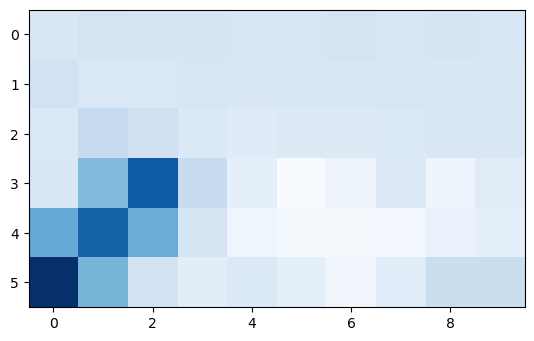

In [129]:
def get_attn(layer, head):
  return attn[f'Layer {layer}'][0][head]

def get_tokens(layer):
  return tokens[f'Layer {layer}'][0]

plt.imshow(get_tokens(layer=0), cmap='Blues', interpolation='nearest')
plt.show()

In [290]:
class transformer_vocab():
  def __init__(self, vocab):
    """Takes a list of unique words in vocab"""
    self.vocab = vocab
    self.indextoword = {i : word for i, word in enumerate(self.vocab)}
    self.wordtoindex = {word: i for i, word in enumerate(self.vocab)} 
  
  def human_readable(self, l):
    return [self.indextoword[i.item()] for i in l]
  
  def machine_readable(self, l):
    return [self.wordtoindex[i] for i in l]

class transformer_trace():
  def __init__(self, tokens, attn, input, logits, vocab):
    self.tokens = tokens
    self.attn = attn
    self.input = input
    self.logits = logits
    self.vocab = vocab

  def human_readable_input(self):
    return [self.vocab.indextoword[i.item()] for i in self.input]

  def get_attn(self, layer, head):
    return self.attn[f'Layer {layer}'][0][head]
  
  def plot_attn(self, layer, head):
    plt.imshow(self.get_attn(layer=layer, head=head), interpolation='nearest')
    plt.ylabel("Attention from")
    plt.xlabel("Attention to")
    plt.xticks(range(len(self.input)), self.vocab.human_readable(self.input))
    plt.yticks(range(len(self.input)), self.vocab.human_readable(self.input))
    plt.show()

  def get_tokens(self, layer):
    return self.tokens[f'Layer {layer}'][0]
  
  def plot_tokens(self, layer):
    plt.imshow(self.get_tokens(layer=layer), interpolation='nearest')
    plt.ylabel("Sequence position")
    plt.xlabel("Token")
    plt.xticks(range(len(self.vocab.vocab)), self.vocab.vocab)
    plt.yticks(range(len(self.input)))
    plt.show()
  
  def top_k_logits(self, k):
    v, ix = torch.topk(self.logits, k, dim=-1)
    out = self.logits.clone()
    out[out < v] = -float('Inf')
    self.logits = out
    return self
  
  def sample(self):
    # apply softmax to convert to probabilities
    probs = self.logits[0].softmax(dim=-1)
    # sample from the distribution or take the most likely
    ix = torch.multinomial(probs, num_samples=1)
    return([self.vocab.wordtoindex[i.item()] for i in ix])
  
  def __str__(self):
    " ".join(self.human_readable_input())

In [280]:
from Decoder_Transformer import DecoderTransformer
import torch
import torch.nn as nn
from torch import optim
import math, copy
from tqdm import tqdm

class DecoderTransformerHandler():
    def __init__(self, model, vocab):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.decoder_transformer = model.to(self.device)
        self.losses = []
        self.vocab = vocab

    @classmethod
    def from_parameters(cls, d_model, vocab, d_ffl=None, height=4, heads=8, dropout=0.1, max_len=5000):
        #vocab should be a list of allowed values
        if d_ffl is None:
            d_ffl = d_model * 4
        model = DecoderTransformer(
          d_model=d_model, 
          vocab=len(vocab), 
          N=height,
          d_ffl=d_ffl, 
          dropout=dropout, 
          h=heads,
          max_len=max_len
        )
        return cls(model, vocab)

    def train(self, train_loader, lr=1e-4, max_epochs=1, loss_fn=nn.CrossEntropyLoss(), test_lambda=None):
        self.decoder_transformer.train()
        optimizer = optim.Adam(self.decoder_transformer.parameters(), lr=lr)
        self.losses = []
        for epoch in range(max_epochs):
            pbar = tqdm(enumerate(train_loader), total=len(train_loader))
            for it, (x, y) in pbar:
                x = x.to(self.device)
                y = y.to(self.device)

                optimizer.zero_grad()

                logits = self.decoder_transformer(x)
                loss = loss_fn(logits.view(-1, logits.size(-1)), y.view(-1))
                loss.backward()
                self.losses.append(loss.cpu().detach().numpy())

                pred = logits.argmax(dim=-1)
                if test_lambda is None:
                    correct = (pred == y).type(torch.float).sum().item()
                else:
                    correct = test_lambda(pred, y).type(torch.float).sum().item()
                accuracy = correct / x.size(0)
                optimizer.step()
                pbar.set_description(f"epoch {epoch} iter {it}: train loss {loss.item():.5f}, accuracy {accuracy*100:0.2f}%")
  
    def test(self, test_loader, test_lambda=None):
        self.decoder_transformer.eval()
        correct = 0
        n = 0
        with torch.no_grad():
            pbar = tqdm(enumerate(test_loader), total=len(test_loader))
            for it, (x, y) in pbar:
                x = x.to(self.device)
                y = y.to(self.device)
                n += x.size(0)
                logits = self.decoder_transformer(x)
                pred = logits.argmax(dim=-1)
                if test_lambda is None:
                    correct += (pred == y).type(torch.float).sum().item()
                else:
                    correct += test_lambda(pred, y).type(torch.float).sum().item()
                accuracy = correct / n
                pbar.set_description(f"iter {it}: test accuracy {accuracy*100:.2f}%")    
    
    def __call__(self, x):
        self.decoder_transformer.eval()
        x = x.to(self.device)
        if len(x.size()) == 1:
            x = x.unsqueeze(0)
        with torch.no_grad():
            logits = self.decoder_transformer(x)
        return logits
    
    def interpreted_trace(self, tokens):
        """tokens is a sentence of tokens"""
        x = torch.tensor([self.vocab.wordtoindex[token] for token in tokens])
        tokens = {}
        attn = {}
        def get_features(name):
            def hook(model, input, output):
                tokens[name] = handler.decoder_transformer.lin(output.detach())
                attn[name] = model.mha.attn.detach()
            return hook
        handles = [self.decoder_transformer.decoder_stack.decoder_blocks[i].register_forward_hook(get_features(f'Layer {i}')) for i in range(len(self.decoder_transformer.decoder_stack.decoder_blocks))]

        logits = self(x)
        for h in handles:
            h.remove()
        
        return transformer_trace(tokens, attn, x, logits, self.vocab)

    def to(self, device):
        self.device = device
        self.decoder_transformer.to(device)

In [136]:
handler = DecoderTransformerHandler.from_parameters(d_model=128,
                                    vocab=transformer_vocab(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']),
                                    height=1,
                                    d_ffl=512, 
                                    dropout=0.1, 
                                    heads=2)
handler.train(train_loader, test_lambda=lambda pred, y: (pred == y)[:, -3:].all(dim=-1))

epoch 0 iter 488: train loss 1.49412, accuracy 42.53%: 100%|██████████| 489/489 [01:12<00:00,  6.76it/s]


In [291]:
handler = DecoderTransformerHandler(handler.decoder_transformer, transformer_vocab(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']))

In [292]:
trace = handler.interpreted_trace(['a','b','c','d','e','f'])

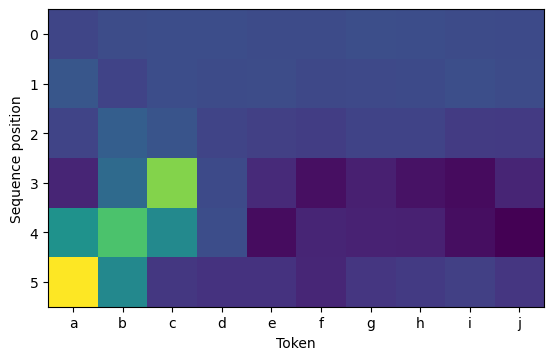

In [293]:
trace.plot_tokens(0)